#Student Name: Justin Helfman
#ECE 595 Machine Learning II
#Project 4: Adversarial Machine Learning - Student Code

In [1]:
#Install Cleverhans (version Cleverhans 2.1.0 is most compatable with Python 2.x)
!pip install cleverhans==2.1.0
!pip install tensorflow==1.13.1
!pip install keras==2.3.0

     |████████████████████████████████| 81kB 4.0MB/s 
     |████████████████████████████████| 163kB 19.7MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 92.5MB 32kB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 368kB 54.8MB/s 
     |████████████████████████████████| 3.2MB 52.0MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 378kB 4.9MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [2]:
#Import necessary packages
from keras.datasets import mnist
from keras import Sequential
from keras.layers import Dense, BatchNormalization
from keras import backend
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import FastGradientMethod, MadryEtAl, DeepFool, CarliniWagnerL2

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

#Part 1: Training a target classifier

In [3]:
# Load data MNIST data and normalize to [0, 1]
#FILL THIS IN
(data_train, labels_train), (data_test, labels_test) = mnist.load_data()
data_train = (data_train/255.0)
data_test = (data_test/255.0)


#Reshape training and testing data into 784-dimensional vectors 
#FILL THIS IN
data_train = data_train.reshape(-1, 784)
data_test = data_test.reshape(-1, 784)

#Convert integer labels for training and testing data into one-hot vectors 
#FILL THIS IN
labels_train = keras.utils.np_utils.to_categorical(labels_train, num_classes=10)
labels_test = keras.utils.np_utils.to_categorical(labels_test, num_classes=10)

#Create classifier architecture, compile it, and train it
#FILL THIS IN

"""
HL 1: dense 100 ReLU in_dim = 784
Batch Norm Layer
HL 2: dense 100 ReLU
Batch Norm Layer
Output Layer: dense 10 units with softmax activation
"""
def Target_Classifier():
  model = Sequential()

  model.add(Dense(100, activation="relu", input_dim=784))
  model.add(BatchNormalization())
  model.add(Dense(100, activation="relu"))
  model.add(BatchNormalization())
  model.add(Dense(10, activation="softmax"))

  return model

targ_class = Target_Classifier()

targ_class.compile(loss="categorical_crossentropy", optimizer="ADAM", metrics=['accuracy'])

epochs = 50
batch_size = 256

targ_class_mdata = targ_class.fit(data_train, labels_train, validation_data=(data_test, labels_test), epochs=epochs, batch_size=batch_size, shuffle=True, verbose=0)


11493376/11490434 [==============================] - 1s 0us/step
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


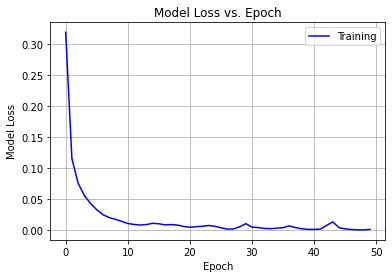

In [4]:
#Plot loss vs epoch
#FILL THIS IN
a = plt.plot(targ_class_mdata.epoch, targ_class_mdata.history['loss'], color='blue', label="Training")
plt.xlabel("Epoch")
plt.ylabel("Model Loss")
plt.title("Model Loss vs. Epoch")
plt.legend(loc="best")
plt.grid('on')

plt.show()

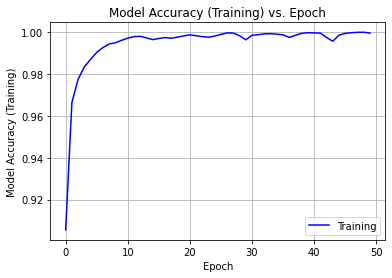

In [5]:
#Plot accuracy vs epoch
#FILL THIS IN
a = plt.plot(targ_class_mdata.epoch, targ_class_mdata.history['accuracy'], color='blue', label="Training")
plt.xlabel("Epoch")
plt.ylabel("Model Accuracy (Training)")
plt.title("Model Accuracy (Training) vs. Epoch")
plt.legend(loc="best")
plt.grid('on')

plt.show()

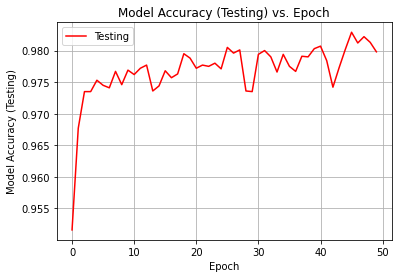

In [6]:
#Print accuracy of classifier on MNIST testing data
#FILL THIS IN
b = plt.plot(targ_class_mdata.epoch, targ_class_mdata.history['val_accuracy'], color='red', label="Testing")
plt.xlabel("Epoch")
plt.ylabel("Model Accuracy (Testing)")
plt.title("Model Accuracy (Testing) vs. Epoch")
plt.legend(loc="best")
plt.grid('on')

plt.show()

In [7]:
# Edit the classifier name fed into KerasModel Wrapper with the name of the 
# classifier from above and then run this block

#Get TensorFlow Session to pass into Cleverhans modules
sess = backend.get_session()

#Create wrapper for classifier model so that it can be passed into Cleverhans modules
wrap = KerasModelWrapper(targ_class)

#Part 2: The Fast Gradient Method (FGM)

In [8]:
#Implementing the FGSM attack

#FGM Instance on trained classifier from Part 1
#FILL THIS IN
fgm_model = FastGradientMethod(wrap, sess=sess)

#Attack parameters
#FILL THIS IN
attack_params = {'eps':0.25, 'clip_min':0.0, 'clip_max':1.0}

#Generate adversarial data
#FILL THIS IN
fgm_model_data = fgm_model.generate_np(data_test, **attack_params)

#Evaluate accuracy on target classifier 
#FILL THIS IN
fgm_model_scores = targ_class.evaluate(fgm_model_data, labels_test)
print(f'Accuracy: {fgm_model_scores}')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

10000/10000 [==============================] - 0s 34us/step
Accuracy: [13.086849398803711, 0.07970000058412552]


Adverserial Samples:    Original Samples:


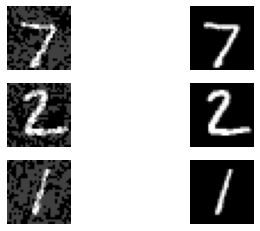

In [9]:
#Show ten original samples and their corresponding adversarial samples
#FILL THIS IN
fig, axs = plt.subplots(3, 2)
count = 0
print("Adverserial Samples:    Original Samples:")

for i in range(3):
  axs[i,0].imshow(fgm_model_data[count].reshape(28, 28), cmap='gray')
  axs[i,0].axis('off')
  axs[i,1].imshow(data_test[count].reshape(28, 28), cmap='gray')
  axs[i,1].axis('off')
  count += 1
plt.show()

In [10]:
#Implementing Detection via Autoencoders

def autoencoder():
    ae = Sequential()
    ae.add(Dense(400, activation=None, kernel_initializer="normal", input_dim=784))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(100, activation=None, kernel_initializer='normal'))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(400, activation=None, kernel_initializer='normal'))
    ae.add(Dense(784, activation='sigmoid', kernel_initializer='normal'))
    return ae

#Create and train the autoencoder using the mean squared error loss and adam optimizer
#FILL THIS IN

In [11]:
#Using the autoencoder for detection and to determine a threshold 

# Create adversarial examples using FGSM on training data
#FILL THIS IN
ae = autoencoder()
ae.compile(loss="mse", optimizer="ADAM")
ae_history = ae.fit(data_train, data_train, validation_data=(data_test, data_test), epochs=epochs, batch_size=batch_size, shuffle=True, verbose=0)
adv_ex_train = ae.predict(fgm_model.generate_np(data_train, **attack_params))

# Obtain reconstruction errors on training set and determine a threshold 
#FILL THIS IN
error = keras.losses.mean_squared_error(data_train, adv_ex_train)

# Convert error tensor into NumPy array 
# CHANGE NAME 'error' TO WHAT YOU CALLED IT ABOVE
error = error.eval(session=sess)

# Determine threshold (based on min in this case) and print it 
#FILL THIS IN
threshold = min(error)
print(f'The threshold is: {threshold}')

# Calculate error of adversarial testing set
#FILL THIS IN
adv_ex_test = ae.predict(fgm_model.generate_np(data_test, **attack_params))
error_test =  keras.losses.mean_squared_error(data_test, adv_ex_test)
error_test = error_test.eval(session=sess)

# Determine how many examples are above threshold and consider them adversarial
# (true positive count)
# Hint: Use a 'for' loop to compare each error value to the threshold
#FILL THIS IN
true_positives = []

for i in error_test:
  if i > threshold:
    true_positives.append(i)

# Print number of true positive samples
#FILL THIS IN  
print(f"The number of true positive samples is: {len(true_positives)}")

# Determine false positives on benign testing set
#FILL THIS IN 


# Determine how many examples are above threshold and consider them adversarial
# (false positive count)
# Hint: Use a 'for' loop to compare each error value to the threshold
#FILL THIS IN 
false_positives = []

for i in error_test:
  if i <= threshold:
    false_positives.append(i)
    
# Print number of false positive samples
#FILL THIS IN  
print(f"The number of false positive samples is: {len(false_positives)}") 

The threshold is: 0.0033357562497258186
The number of true positive samples is: 10000
The number of false positive samples is: 0


#Part 3: Projected Gradient Descent

In [12]:
#Implementing the PGD attack

#PGD Instance on trained classifier from Part 1
pgd = MadryEtAl(wrap, sess=sess)

#Attack parameters
#FILL THIS IN
attack_params = {"eps": 0.25, "eps_iter": 0.01, "nb_iter": 20, 'clip_min':0.0, 'clip_max':1.0}

#Generate adversarial data
#FILL THIS IN
pgd_model_data = pgd.generate_np(data_test, **attack_params)

#Evaluate accuracy of perturbed data on target classifier
#FILL THIS IN
pgd_model_scores = targ_class.evaluate(pgd_model_data, labels_test)
print(f'Accuracy: {pgd_model_scores}')

10000/10000 [==============================] - 0s 37us/step
Accuracy: [15.873559106445313, 0.008100000210106373]


Adverserial Samples:    Original Samples:


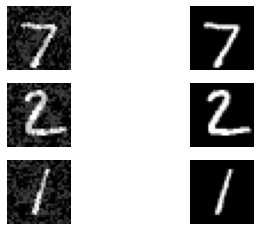

In [13]:
#Show ten original samples and their corresponding adversarial samples
#FILL THIS IN 

fig, axs = plt.subplots(3, 2)
count = 0
print("Adverserial Samples:    Original Samples:")

for i in range(3):
  axs[i,0].imshow(pgd_model_data[count].reshape(28, 28), cmap='gray')
  axs[i,0].axis('off')
  axs[i,1].imshow(data_test[count].reshape(28, 28), cmap='gray')
  axs[i,1].axis('off')
  count += 1
plt.show()

In [14]:
#Implementing the adversarial training defense
#FILL THIS IN
pgd_model_data_train = pgd.generate_np(data_train, **attack_params)

adv_trained_clf = targ_class 
adv_trained_clf.fit(pgd_model_data_train, labels_train, validation_data=(pgd_model_data, labels_test), epochs=epochs, batch_size=batch_size, shuffle=True, verbose=0) #retraining classifier

In [15]:
#Using the defense to evaluate the accuracy of the perturbed data
#FILL THIS IN 
pgd_model_scores_pert = adv_trained_clf.evaluate(pgd_model_data, labels_test)
print(f'Accuracy: {pgd_model_scores_pert}')

10000/10000 [==============================] - 0s 37us/step
Accuracy: [0.28249301410524447, 0.9789999723434448]


#Part 4: Carlini and Wagner Attack

In [16]:
#Implementing the CW attack

#CW Instance on trained classifier from Part 1
#FILL THIS IN
cw = CarliniWagnerL2(wrap,sess=sess)

#Attack parameters
#FILL THIS IN
attack_params = {"binary_search_steps": 1, "y": None, "learning_rate": 1.25, "batch_size": 16, "initial_const": 10, "clip_min": 0.0, "clip_max": 1.0}

#Generate adversarial data
#FILL THIS IN
cw_model_data = pgd.generate_np(data_test, **attack_params)

#Evaluate accuracy of perturbed data on target classifier
#FILL THIS IN
cw_model_scores = targ_class.evaluate(cw_model_data, labels_test)
print(f'Accuracy: {cw_model_scores}')

/usr/local/lib/python3.6/dist-packages/cleverhans/attacks.py:179: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "


10000/10000 [==============================] - 0s 34us/step
Accuracy: [14.465923989868164, 0.10249999910593033]


Adverserial Samples:    Original Samples:


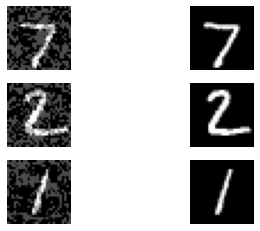

In [17]:
#Show ten original samples and their corresponding adversarial samples
#FILL THIS IN 
fig, axs = plt.subplots(3, 2)
count = 0
print("Adverserial Samples:    Original Samples:")

for i in range(3):
  axs[i,0].imshow(cw_model_data[count].reshape(28, 28), cmap='gray')
  axs[i,0].axis('off')
  axs[i,1].imshow(data_test[count].reshape(28, 28), cmap='gray')
  axs[i,1].axis('off')
  count += 1
plt.show()

In [18]:
#Implementing the dimensionality reduction (PCA) defense 

#Calculate PCA projection
pca = PCA(100)
pca.fit(data_train)
pca_train = pca.transform(data_train)
pca_test = pca.transform(data_test)

#Transform perturbed CW data using the subspace from the original training data
#FILL THIS IN 

# create model for PCA
def pca_model():
    model = Sequential()
    
    #FILL THIS IN 
    model.add(Dense(100, activation="relu", input_dim=100))
    model.add(BatchNormalization())
    model.add(Dense(100, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dense(10, activation="softmax"))

    return model

#Create model graph, compile it, and train it using pca_train lables_train 
#FILL THIS IN 
batch_size = 256
epochs = 50

pca = pca_model()

pca.compile(loss="categorical_crossentropy", optimizer="ADAM")

pca_mdata = pca.fit(pca_train, labels_train, validation_data=(pca_test, labels_test), epochs=epochs, batch_size=batch_size, shuffle=True, verbose=0)

In [19]:
#Using the defense (and comparing to baseline accuracy)
#FILL THIS IN 
pca_model_scores_pert = pca.evaluate(pca_test, labels_test)
print(f'Accuracy: {pca_model_scores_pert}')

10000/10000 [==============================] - 0s 33us/step
Accuracy: 0.1068273107449957


#Part 5: DeepFool 

In [20]:
#Implementing the DeepFool attack

#DeepFool Instance on trained classifier from Part 1
#FILL THIS IN
df = DeepFool(wrap,sess=sess)

#Attack parameters
#FILL THIS IN
attack_params = {"nb_candidate": 10, "max_iter": 50, "clip_min": 0.0, "clip_max": 1.0}

#Generate adversarial data
#FILL THIS IN
df_data = df.generate_np(data_test, **attack_params)

#Evaluate accuracy of perturbed data on target classifier
#FILL THIS IN
df_model_scores = targ_class.evaluate(df_data, labels_test)
print(f'Accuracy: {df_model_scores}')

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
10000/10000 [==============================] - 0s 35us/step
Accuracy: [1.3679793769836426, 0.09520000219345093]


Adverserial Samples:    Original Samples:


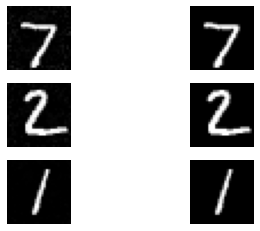

In [21]:
#Show ten original samples and their corresponding adversarial samples
#FILL THIS IN
fig, axs = plt.subplots(3, 2)
count = 0
print("Adverserial Samples:    Original Samples:")

for i in range(3):
  axs[i,0].imshow(df_data[count].reshape(28, 28), cmap='gray')
  axs[i,0].axis('off')
  axs[i,1].imshow(data_test[count].reshape(28, 28), cmap='gray')
  axs[i,1].axis('off')
  count += 1
plt.show()

In [24]:
#Implementing the Denoising Autoencoder Defense

def autoencoder():
    ae = Sequential()
    ae.add(Dense(400, activation=None, kernel_initializer="normal", input_dim=784))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(100, activation=None, kernel_initializer='normal'))
    ae.add(Dense(200, activation=None, kernel_initializer='normal'))
    ae.add(Dense(400, activation=None, kernel_initializer='normal'))
    ae.add(Dense(784, activation='sigmoid', kernel_initializer='normal'))
    return ae

#Create training data for DAE 
df_attack_data_train = df.generate_np(data_train, **attack_params)
data_total_train = np.concatenate([df_attack_data_train, data_train])

#Create and train DAE graph
#FILL THIS IN
dae = autoencoder()
dae.compile(loss="mse", optimizer="ADAM")
dae_history = dae.fit(data_train, data_train, validation_data=(data_test, data_test), epochs=50, batch_size=batch_size, shuffle=True, verbose=0)

In [26]:
#Using the defense

#Use DAE to to remove adversarial perturbation 
#FILL THIS IN
attack_params = {"eps": 0.25, "clip_min": 0.0, "clip_max": 1.0}
df_no_pertubation = df.generate_np(data_test, **attack_params)

#Evaluate accuracy of FGM samples after denoising 
#FILL THIS IN
dae_test = dae.predict(df_no_pertubation)

/usr/local/lib/python3.6/dist-packages/cleverhans/attacks.py:179: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "


Adverserial Samples:    Original Samples:


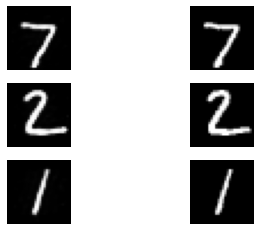

In [27]:
#Show ten samples of adversarial samples after denoising
#FILL THIS IN
fig, axs = plt.subplots(3, 2)
count = 0
print("Adverserial Samples:    Original Samples:")

for i in range(3):
  axs[i,0].imshow(dae_test[count].reshape(28, 28), cmap='gray')
  axs[i,0].axis('off')
  axs[i,1].imshow(data_test[count].reshape(28, 28), cmap='gray')
  axs[i,1].axis('off')
  count += 1
plt.show()